In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
business = pd.read_csv('data/business.csv')
economy = pd.read_csv('data/economy.csv')

In [3]:
def clean(df, class_):
    def extract_stops(description):
        stops_match = re.search(r'(\d+)-?stop', description)
        if stops_match:
            return int(stops_match.group(1))
        else:
            return 0
    def duration_to_hours(duration):
        hours, minutes = duration.split('h ')
        hours = float(hours.strip()) if len(hours.strip()) > 1 else 0
        minutes = int(minutes[:-1].strip()) if len(minutes.strip()) > 1 else 0
        total_hours = hours + minutes / 60
        return round(total_hours, 3)
    df_copy = df.copy()
    df_copy["price"] = df_copy["price"].str.replace("," , "").astype(int)
    df_copy["flight_code"] = df_copy["ch_code"].astype(str).str.cat(df_copy["num_code"].astype(str), sep="_")
    df_copy['num_stops'] = df_copy['stop'].apply(extract_stops)
    df_copy["time_taken"] = df_copy["time_taken"].apply(duration_to_hours)
    df_copy['date'] = pd.to_datetime(df_copy['date'], format="%d-%m-%Y")
    df_copy['day_of_week'] = df_copy['date'].dt.dayofweek
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
    df_copy['arr_time'] = df_copy['arr_time'].dt.hour + (df_copy['arr_time'].dt.minute >= 30)
    df_copy['dep_time'] = pd.to_datetime(df_copy['dep_time'])
    df_copy['dep_time'] = df_copy['dep_time'].dt.hour + (df_copy['dep_time'].dt.minute >= 30)
    df_copy = df_copy.drop(columns= ["date", "ch_code", "num_code", "stop"])
    df_copy["class"] = class_
    df_copy = df_copy[["airline", "flight_code", "class", "from", "to", "time_taken", "dep_time", "arr_time", "num_stops", "month", "day_of_week", "price"]]
    return df_copy

    

In [4]:
cleaned_df = pd.concat([clean(economy, "economy"), clean(business, "business")])
cleaned_df

/var/folders/80/vdccj0dj1cs241gycwjdbz580000gn/T/ipykernel_28619/221602428.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
/var/folders/80/vdccj0dj1cs241gycwjdbz580000gn/T/ipykernel_28619/221602428.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['dep_time'] = pd.to_datetime(df_copy['dep_time'])
/var/folders/80/vdccj0dj1cs241gycwjdbz580000gn/T/ipykernel_28619/221602428.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
/var/folders/80/vdccj0

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,SpiceJet,SG_8709,economy,Delhi,Mumbai,2.167,19,21,0,2,4,5953
1,SpiceJet,SG_8157,economy,Delhi,Mumbai,2.333,6,9,0,2,4,5953
2,AirAsia,I5_764,economy,Delhi,Mumbai,2.167,4,7,0,2,4,5956
3,Vistara,UK_995,economy,Delhi,Mumbai,2.250,10,13,0,2,4,5955
4,Vistara,UK_963,economy,Delhi,Mumbai,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,Vistara,UK_822,business,Chennai,Hyderabad,10.083,10,20,1,3,3,69265
93483,Vistara,UK_826,business,Chennai,Hyderabad,10.417,13,23,1,3,3,77105
93484,Vistara,UK_832,business,Chennai,Hyderabad,13.833,7,21,1,3,3,79099
93485,Vistara,UK_828,business,Chennai,Hyderabad,10.000,7,17,1,3,3,81585


In [6]:
cleaned_df.describe()

,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
count,300261.000000,300261.000000,300261.00000,300261.000000,300261.000000,300261.000000,300261.000000
mean,12.217291,13.509850,15.80090,0.835703,2.664995,2.954656,20883.717666
std,7.193560,5.412152,6.05027,0.370546,0.471993,2.003251,22695.911266
min,0.333000,0.000000,0.00000,0.000000,2.000000,0.000000,1105.000000
25%,6.750000,9.000000,11.00000,1.000000,2.000000,1.000000,4783.000000
50%,11.250000,13.000000,17.00000,1.000000,3.000000,3.000000,7425.000000
75%,16.167000,19.000000,21.00000,1.000000,3.000000,5.000000,42521.000000
max,49.833000,24.000000,24.00000,1.000000,3.000000,6.000000,123071.000000


Let's first visualize the number of flights by Airline within our dataset.

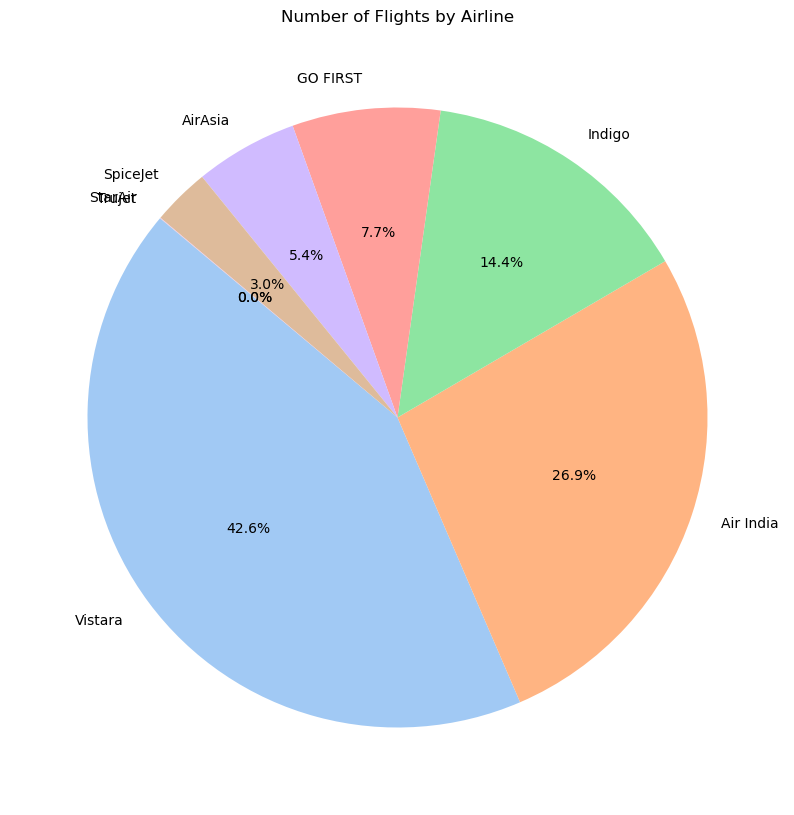

In [44]:
plt.figure(figsize=(10, 15))
airline_counts = cleaned_df['airline'].value_counts()
plt.pie(airline_counts, labels=airline_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Number of Flights by Airline')
plt.show()

In [18]:
cleaned_df['airline'].value_counts()

airline
Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

It looks like Vistara has by far the most flight data, making up almost half of our dataset, while Trujet and StarAir have very little data (less than 1% of our dataset).

Is there variation in flight prices depending on the day of the week?

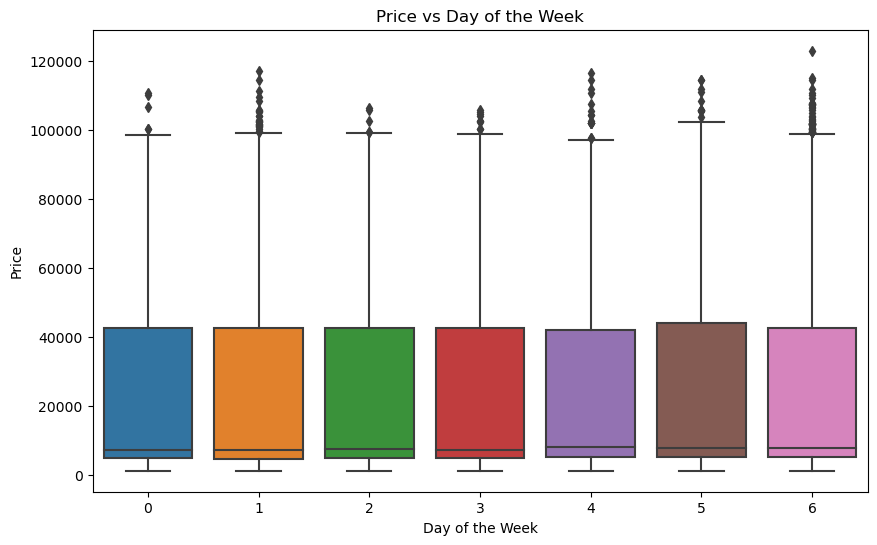

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='price', data=cleaned_df)
plt.title('Price vs Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Price')
plt.show()

It looks like flight prices are generally relatively stable regardless of the day of the week, with similar distributions for each day. However, this does not take into account differences in pricing between different airlines. If we look at a specific airline, Vistara, does this change?

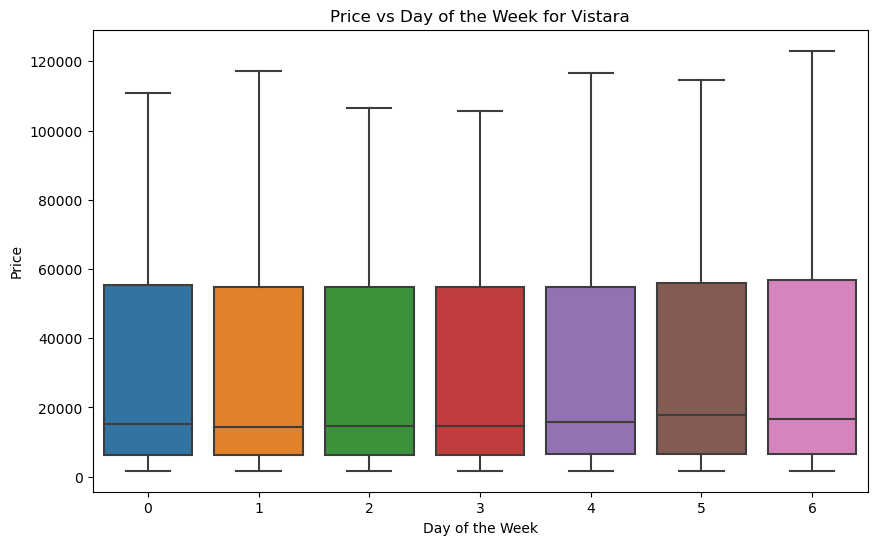

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='price', data=cleaned_df[cleaned_df['airline'] == 'Vistara'])
plt.title('Price vs Day of the Week for Vistara')
plt.xlabel('Day of the Week')
plt.ylabel('Price')
plt.show()

We can see more clearly that the median prices are relatively stable, with the most expensive flights being toward the weekend rather than in the middle of the week. Compared to the combined data for all airlines, we see that the median price for each day is significantly higher (closer to 20000), which indicates that Vistara has generally more expensive flights than other airlines.

We can take a look at the distribution of prices by airline.

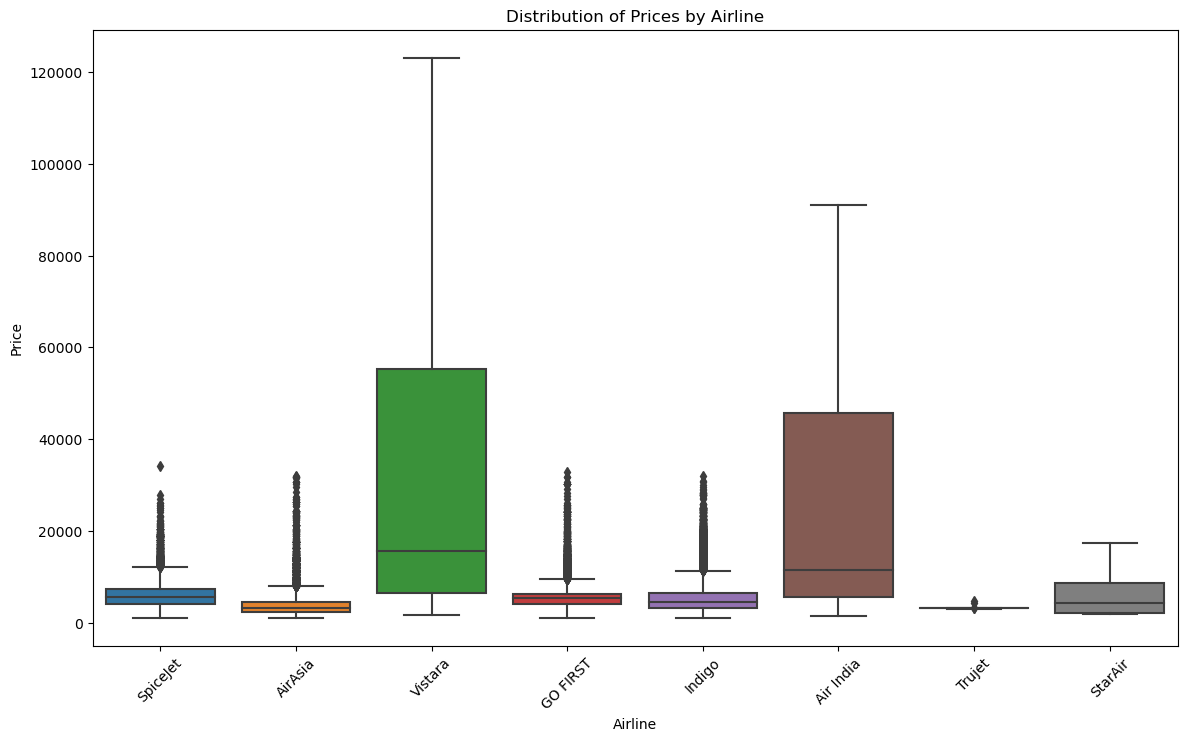

In [20]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='airline', y='price', data=cleaned_df)
plt.title('Distribution of Prices by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

Here, we can see that Vistara and Air India have the most expensive flights, with a larger range of flight prices. For all airlines, the median price is below 20000.

In [27]:
cleaned_df['month'].value_counts()

month
3    199672
2    100589
Name: count, dtype: int64

It looks like all of our flight data comes from either February or March, and there is more data on flights from March and February.

Let's see if there are any patterns with departure time and pricing.

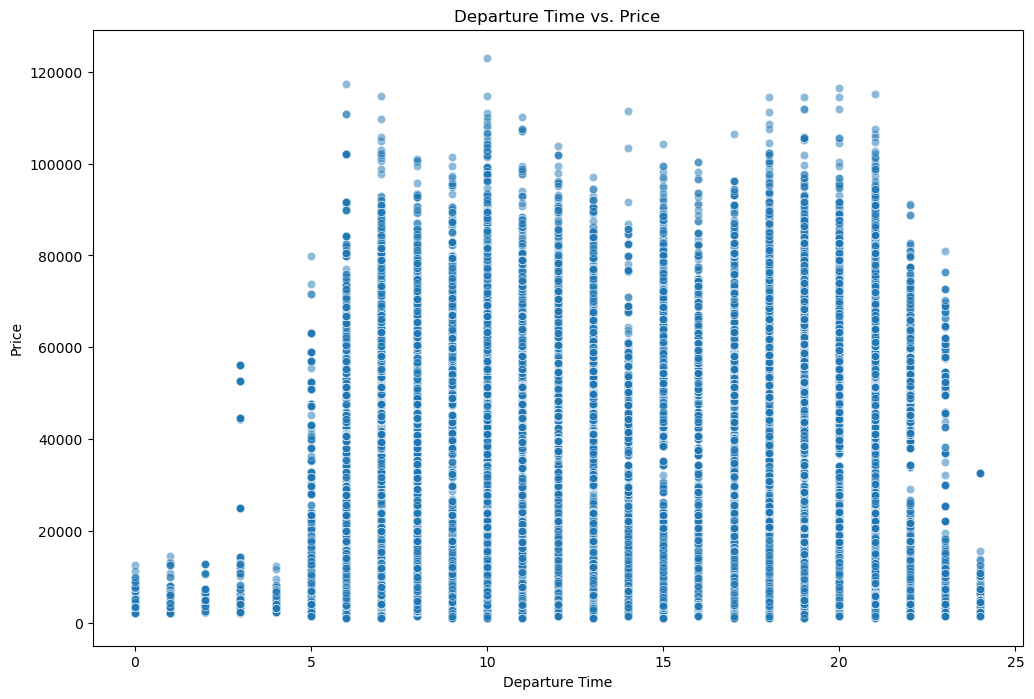

In [29]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='dep_time', y='price', data=cleaned_df, alpha=0.5)
plt.title('Departure Time vs. Price')
plt.xlabel('Departure Time')
plt.ylabel('Price')
plt.show()

We can see that flights the depart between around 11pm-5am are significantly rarer and cheaper than other departure times.

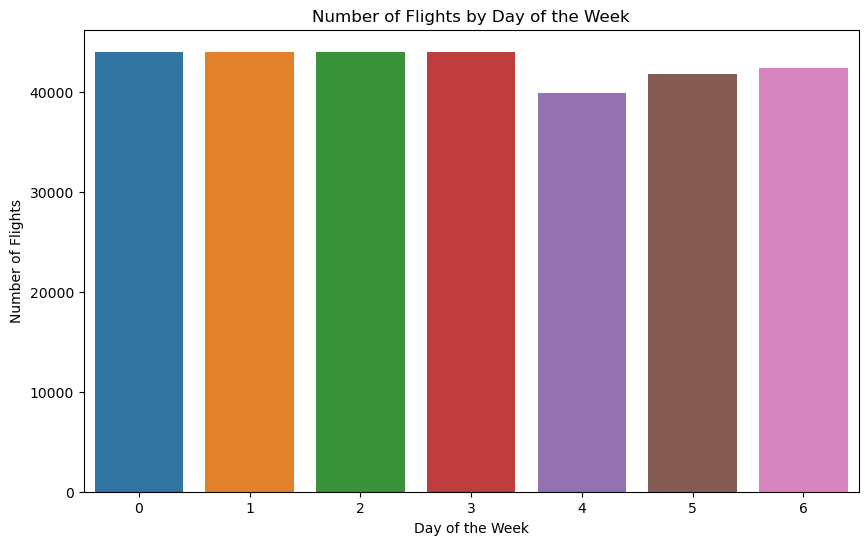

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=cleaned_df)
plt.title('Number of Flights by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.show()

Given this bar chart, it seems that we have around the same amount of flight data for every day of the week.